# Predicting Flight Delays

### Section 5 Team 3

Marguerite Morgan, margueritemorgan@berkeley.edu \
Saniya Lakka, saniyalakka@berkeley.edu \
Rohit Bakshi, rohitbakshi@berkeley.edu \
Sitao Chen, chensitao@berkeley.edu

## Abstract
A quarter of flights were delayed between January and June of 2022, causing disruption to many passenger’s schedules and trips. This inconvenience begs the question: Can we classify flights as delayed or not delayed to ensure passengers can make adjustments to their schedules? Utilizing flight, weather and airport datasets, we developed various classification models that provide a predictive status update of whether a flight will be delayed or not given its arrival status. The steps to achieving this outcome required 1) pre-processing of the three joined datasets and feature engineering of new flight, weather and station characteristics  2) Using logistic regression to create the baseline model with AUC of .54, 3) Developing classification models, such as, Decision Tree (test AUC score of ~0.83), Random Forest (test AUC score of ~0.74), Neural Network (test AUC score of 0.61) and Ensembling (test AUC score of 0.64). We will be using AUC score, precision and recall as evaluation metrics. We use 2021 data as a test set initially, but find that volatility regimes cause the model to perform worse for 2021 compared to other years. The end result is a model that presents passengers with a predicted flight status 2 hours before their flight so that they can plan accordingly. Our best model was an ensemble model containing our best models from decision trees, random forests and a multi-layer-perceptron neural network that had the best evaluation metrics in AUC, precision and recall for both training and test data sets.


https://www.businessinsider.com/us-airlines-canceled-delayed-most-flights-list-travel-chaos-republic-2022-8

# Introduction

### Problem
Flight delays are very common and became exasperated by the pandemic in recent years. For passengers, flight delays often mean scheduling problems such as missing connecting flights or missing a ride from the destination airport to a passenger's hotel or home. Airlines are required to notify passengers of a delay within 30 minutes of learning of a status change. However, there is still a lot of variability in when airlines announce these delays and often times it happens less than an hour before the flight's scheduled departure time. Our model will allow passengers to consistently have awareness of any potential delay 2 hours prior to their estimated departure time, allowing passengers time to make alternate plans as needed such as finding another connecting flight or giving their ride notice that they will likely be delayed. But what is a flight delay exactly? The FAA defines a flight as delayed if it takes off or lands more than 15 minutes later than scheduled. However, flights that take off 15 minutes late can often still arrive on time as pilots are frequently able to make up for a 15 minute delay in the air. Additionally, even if a pilot is unable to make up for the 15 minute delay in the air, arriving 15 minutes late often has minimal impact on passengers. Often times, passengers give themselves at least a 15 minute buffer when making transportation plans or scheduling connecting flights given how common it is to experience this type of delay. A 30 minute arrival delay is more likely to have meaningful, negative impact on a passenger's schedule. The shortest layover between connecting domestic flights that passeneger's will schedule is ~30 minutes. This means if their first flight arrives 30 minutes late, they will not have any chance of making their connection. Airlines also recognize the impact of a 30 minute delay is this the minimum threshold that requires airlines to update all flight status displays with the delay. Thus, our model will predict ~2 hours prior to a flight's estimated departure whether or not the flight will arrive more than 30 minutes late. This will allow passengers to consistently have awareness of an impactful delay and adjust their flight connections or other scheduled transportation accordingly.

### Dataset
There are 3 primary datasets we are working with: flight data, weather data, and station data. The flight data generally contains information about flights
throughout the US from 2015 - 2021 such as flight time, origin location, destination location, airline, and whether the flight was delayed. The shape of the flight data is ~74M rows and 109 columns. The weather data contains information collected throughout the day from 2015-2021 from various weather stations all over the world. These weather readings are taken from multiple different devices, represented as report types in the data. The weather data contains information such as wind speed and amount of preciptation. The shape of the weather data is ~899M rows and 124 columns. The station data contains the latitude and longitude of each weather station, its corresponding airport ID, and the distance to other weather stations. The station data is ~5M rows and has 12 columns.

**Target Variable:** Our target variable will be the arrival delay. Given we are focusing on the perspective of a passenger, an arrival delay is more important than a departure delay. As a passenger, you care less about whether you're taking off on time as long as you arrive at your destination at the expected time. Thus, "ARR_DELAY_NEW" is our key target variable - this version of the variable sets any early arrivals to 0. Arrival delay has a right skewed distribution with a max arrival delay of ~33 minutes and a mean of ~13 minutes. About 20% of flights are more than 15 minutes delayed, ~18% are more than 20 minutes delayed and ~13% are more than 30 minutes delayed. From a passenger perspective, it's likely that a delay of 30 minutes or more would have potential meaningful negative impact on that passenger's schedule (as opposed to 15-20 minutes). Thus, we will proceed with the indicator variable "ARR_DEL30" as our target variable.

### Metrics
We will measure performance across 3 key metrics: recall, precision and AUC. The dataset is imbalanced; only ~15% of flights in the dataset have an arrival delay of >30 minutes. Thus, we want to look beyond accuracy to understand not just how often our model predicts the appropriate outcome but how often it correctly predicts a delayed flight out of all the flights actually delayed as well as how often this prediction is correct out of all instances where our model makes this prediction. We also want to understand how our model balances these two dyanimcs, which will be reflected in the AUC score. Area under the ROC Curve. An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate and False Positive Rate. AUC provides an aggregate measure of performance across all possible classification thresholds. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.
We will aim for an AUC metric that is greater than 0.6 which means our model ranks a random delayed flight example higher than a random non delayed flight example >60% of the time; this is 10% higher than random chance. We will also aim for recall and precision to be roughly balanced i.e. within 10% of each other so that we're appropriately optimizing for catching all delayed flights in our model without overflagging them.

**Recall** = True Positive / (True Positive + False Negative)

**Precision** = True Positive / (True Positive + False Positive)

d
### Modeling Pipeline

Throughout our modeling pipeling, we were careful to avoid data leakage. Data leakage refers to using data for training and validating a model that would not be available at the time of prediction. For example, if we leveraged the average precipitation on a given day across the years 2015 - 2021 and used that to train a model that was predicting flight delays in 2021, we would be potentially leveraging weather from 2021 that wasn't available yet at the time we'd be theoretically running our model; this means our model would have leakage.

The first step of our overall modeling pipeline involved reading in our 3 datasets as parquet files and joining them together 1 year at a time; we then concatenated all the years together to get one final joined dataset. We avoided leakage in our join approach by ensuring we only brought in weather datapoints that happened prior to a flight's estimated departure time and therefore prior to the time at which the model would be run in practice. The second step of our pipeline included cleaning the data and engineering features. When filling null values in our data cleaning steps, we again avoided leakage by filling them with the average feature for that day on years prior. Similarly, we avoided leakage when engineering features such as the tail number delay by only looking at the delay of a flight's tail number for the prior flight as opposed to subsequent flights. Once we had our cleaned data set with features of interest, we split our data into a train and test set ensuring that our train set time period always came prior to our test set time period. This ensured we were building models on historical data that would then be leveraged to predict future flights. Finally, we built logistic regression, random forest, decision tree, and ensemble models in order to identify the most predictive model for passengers. Throughout our modeling pipeline we ensured that at each step we avoided data leakage so that our model is effective and generalizable for predicting flights in the future.


<img src="https://github.com/saniyalakka19/flight_delay_final_project/blob/main/model_pipeline_final.png?raw=true" width=70%>

In [ ]:
# Imports

from pyspark.sql.functions import concat, lit, col, unix_timestamp, expr, broadcast, when, lpad, explode, array, row_number
from pyspark.ml.stat import Correlation

import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import max as max_
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import round
from pandas.tseries.holiday import USFederalHolidayCalendar


import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from pyspark.ml.linalg import DenseVector, SparseVector, Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, StringIndexer, OneHotEncoder
from pyspark.ml.functions import vector_to_array



from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import col, explode, array, lit


from timezonefinder import TimezoneFinder

# Pre-Processing

Pre-processing invovles the following steps: <br><br>
1. The join
2. Cleaning the data: converting to correct data types and filling nulls
3. Feature Engineering
4. Exploratory Analysis of the data

### The Join
The overall join approach included bringing in the latest weather reading that occurred prior to 2 hours before a flight's estimated departure time near both the flight origin and destination. In order to do this, we needed to identify the relevant weather station for each airport, standardize flight departure times and weather reading times from local times to UTC, and identify the latest weather reading at both the origin and destination that occurred prior to 2 hours before a flight's departure time. We completed these tasks 1 year at a time and then combined all of the years together at the end.

#### Join Stats for a given year (2015)
**Cleaned Flight Data:** 5,714,008 rows, 19 columns \
**Cleaned Weather Data:** 62,154,801 rows, 20 columns \
**Cleaned Station Data:** 2,261 rows, 6 columns

| Join | Data Set 1 | Data Set 2 | Join Type | Join Key | Run Time | Cluster Size
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| #1: Station & Flight Data to get station, lat and lon per flight  | Flight data | Station data | Left join | Origin & Dest Airport, Origin & Dest State| ~1.5 minutes | Standard 16GB 4 cores|
| #2: Weather & Flight Data to get latest weather timestamp at origin and dest  | Flight data | Weather data | Left join | Origin & Dest Airport| ~15 minutes | Standard 16GB 4 cores|
| #3: Weather & Flight Data to bring in weather columsn to flight data  | Flight data | Weather data | Left join | Origin & Dest Airport, latest weather timestamp | ~2 minutes | Standard 16GB 4 cores|

In [ ]:
#pip install timezonefinder

#### The Steps:

Step 1: Load each full dataset as a parquet file, select year, clean and select relevant columns <br>
Repeat 2-6: <br>
Step 2: Join relevant weather station and corresponding latitude / longitude to each flight <br>
Step 3: Convert local timezones to UTC in flight data and weather data <br>
Step 4: Identify latest weather timestamp for that happens at least 2 hours prior to estimated departure time at origin and destination <br>
Step 5: Join weather data and flight data based on station and latest weather timestamp <br>
Step 6: Write Data
Step 7: Combine all data
Step 8: Write combined data

In [ ]:
def write_loc():

    blob_container = "blobcontainer1" # The name of your container created in https://portal.azure.com
    storage_account = "w261section5team3" # The name of your Storage account created in https://portal.azure.com
    secret_scope = "scope1" # The name of the scope created in your local computer using the Databricks CLI
    secret_key = "key1" # The name of the secret key created in your local computer using the Databricks CLI
    blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
    mount_path = "/mnt/mids-w261"

    spark.conf.set(
      f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
      dbutils.secrets.get(scope = secret_scope, key = secret_key)
    )

    return blob_url

In [ ]:
def read_data(data_BASE_DIR):

    # Load full data for Flights
    df_airlines = spark.read.parquet(f"{data_BASE_DIR}parquet_airlines_data/")

    # Load full data for Weather
    df_weather = spark.read.parquet(f"{data_BASE_DIR}parquet_weather_data/")

    # Load the stations data
    df_stations = spark.read.parquet(f"{data_BASE_DIR}stations_data/*")

    return df_airlines, df_weather, df_stations

In [ ]:
def run_join_on_year(year: str):
    # Split by year -- INPUT CHOSEN YEAR
    df_airlines = df_airlines.filter(df_airlines.YEAR == year)
    df_weather = df_weather.filter(df_weather.YEAR == year)
    return df_airlines, df_weather

In [ ]:
def prepare_weather_data(df_weather):

    # Select the report type that is most common in the data in order to only have 1 weather reading per station per datetime
    df_weather_v2 = df_weather.filter(df_weather.REPORT_TYPE == 'FM-15')

    # Subset for only key columns
    weather_cols = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation',
                   'HourlyPressureChange', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySkyConditions', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed']
    df_weather_v2 = df_weather_v2.select([col for col in weather_cols])

    # Create unique ID
    df_weather_v2 = df_weather_v2.select("*", concat(col("STATION"),lit(" "),col("DATE")).alias("WEATHER_UNIQUE_ID"))

    return df_weather_v2

In [ ]:
def prepare_flight_data(df_airlines):

    # Subset for only key columns
    flight_cols = ['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'TAIL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'DISTANCE', 'AIR_TIME']

    # Remove cancelled & diverted flights
    df_airlines_v2 = df_airlines.filter((df_airlines.CANCELLED == 0) & (df_airlines.DIVERTED == 0))
    df_airlines_v2 = df_airlines_v2.select([col for col in flight_cols])

    # Drop all duplicate flights
    df_airlines_v2 = df_airlines_v2.distinct()

    # Create unique flight ID
    df_airlines_v2 = df_airlines_v2.select("*", concat(col("FL_DATE"),lit(" "),col("OP_UNIQUE_CARRIER"),lit(" "), col("OP_CARRIER_FL_NUM"), lit(" "), col("ORIGIN"), lit(" "), col("DEST")).alias("FLIGHT_UNIQUE_ID"))
    df_airlines_v2 = df_airlines_v2.dropDuplicates(["FLIGHT_UNIQUE_ID"])

    return df_airlines_v2

In [ ]:
def prepare_station_data(df_stations):

    # subset for only stations themselves (as opposed to neighboring stations)
    df_stations_v2 = df_stations.filter(df_stations.distance_to_neighbor == 0)

    # Subset for only key columns
    station_cols = ['station_id', 'lat', 'lon', 'neighbor_call', 'neighbor_state']
    df_stations_v2 = df_stations_v2.select([col for col in station_cols])

    # Create unique station ID
    df_stations_v2 = df_stations_v2.select("*", concat(col("station_id"),lit(" "),col("neighbor_state"),lit(" "),col("neighbor_call")).alias("STATION_UNIQUE_ID"))

    return df_stations_v2

In [ ]:
def join_airline_station(df_airlines_v2, df_stations_v2):

    # Remove first character of neighbor_call in order to match with origin and destination in flight data
    df_stations_v2 = df_stations_v2.withColumn("neighbor_call_v2", expr("substring(neighbor_call, 2, length(neighbor_call))"))

    # Get distinct origin and destination airpors and states
    origins = df_airlines_v2.select(["ORIGIN", "ORIGIN_STATE_ABR"]).distinct()
    dests = df_airlines_v2.select("DEST", "DEST_STATE_ABR").distinct()

    # Join relevant station and corresponding lat / lon to each flight for origin
    airlines_stations_origin = origins.join(df_stations_v2, (origins.ORIGIN == df_stations_v2.neighbor_call_v2) & (origins.ORIGIN_STATE_ABR == df_stations_v2.neighbor_state), "left")
    airlines_stations_origin = airlines_stations_origin.withColumnRenamed("lat","ORIGIN_LAT").withColumnRenamed("lon", "ORIGIN_LON").withColumnRenamed("station_id", "ORIGIN_STATION_ID").withColumnRenamed("neighbor_call_v2", "ORIGIN_NEIGHBOR_CALL")
    airlines_stations_origin = airlines_stations_origin.drop("neighbor_call", "neighbor_state", "STATION_UNIQUE_ID")

    # Join relevant station and corresponding lat / lon to each flight for destination
    airlines_stations_dest = dests.join(df_stations_v2, (dests.DEST == df_stations_v2.neighbor_call_v2) & (dests.DEST_STATE_ABR == df_stations_v2.neighbor_state), "left")
    airlines_stations_dest = airlines_stations_dest.withColumnRenamed("lat","DEST_LAT").withColumnRenamed("lon", "DEST_LON").withColumnRenamed("station_id", "DEST_STATION_ID").withColumnRenamed("neighbor_call_v2", "DEST_NEIGHBOR_CALL")
    airlines_stations_dest = airlines_stations_dest.drop("neighbor_call", "neighbor_state", "STATION_UNIQUE_ID")

    # Join back to flight dataframe
    df_airlines_stations = df_airlines_v2.join(airlines_stations_origin, ["ORIGIN"], "left").join(airlines_stations_dest, ["DEST"], "left").distinct()

    return df_airlines_stations


In [ ]:
def timzone_conversion(df_airlines_stations):

    # Pull out unique latitudes and longitudes from airports
    origin_lat_lons = df_airlines_stations.select(['ORIGIN_LAT', 'ORIGIN_LON']).distinct()
    origin_lat_lons = origin_lat_lons.toPandas().dropna()

    dest_lat_lons = df_airlines_stations.select(['DEST_LAT', 'DEST_LON']).distinct()
    dest_lat_lons = dest_lat_lons.toPandas().dropna()

    # Identify time zone based on lat and lon
    timezone_func = TimezoneFinder().timezone_at
    origin_lat_lons['ORIGIN_TIMEZONE'] = origin_lat_lons.apply(lambda x: timezone_func(lng=x['ORIGIN_LON'], lat=x['ORIGIN_LAT']), axis=1)
    dest_lat_lons['DEST_TIMEZONE'] = dest_lat_lons.apply(lambda x: timezone_func(lng=x['DEST_LON'], lat=x['DEST_LAT']), axis=1)

    origin_lat_lons = origin_lat_lons.drop_duplicates()
    dest_lat_lons = dest_lat_lons.drop_duplicates()

    origin_lat_lons_spark = spark.createDataFrame(origin_lat_lons)
    dest_lat_lons_spark = spark.createDataFrame(dest_lat_lons)

    # Join back to airlines dataframe
    df_airlines_stations_v2 = df_airlines_stations.join(origin_lat_lons_spark,["ORIGIN_LAT", "ORIGIN_LON"], "left") \
         .join(dest_lat_lons_spark,["DEST_LAT", "DEST_LON"], "left")

    # Calculate standardized timestamp of estimated departure time in flight data
    df_airlines_stations_v2 = df_airlines_stations_v2.withColumn("CRS_DEP_TIME", df_airlines_stations_v2.CRS_DEP_TIME.cast(StringType()))
    df_airlines_stations_v2 = df_airlines_stations_v2.withColumn("CRS_DEP_TIME_UPD", when(F.length("CRS_DEP_TIME")<4, lpad(df_airlines_stations_v2.CRS_DEP_TIME, 4, '0')).otherwise(df_airlines_stations_v2.CRS_DEP_TIME))

    df_airlines_stations_v3 = df_airlines_stations_v2\
      .withColumn("DEP_TIMESTAMP", unix_timestamp(concat(df_airlines_stations_v2.FL_DATE, df_airlines_stations_v2.CRS_DEP_TIME_UPD), "yyyy-MM-ddHHmm")\
      .cast("timestamp"))

    df_airlines_stations_v3 = df_airlines_stations_v3.withColumn("DEP_TIMESTAMP_UTC", to_utc_timestamp(df_airlines_stations_v3.DEP_TIMESTAMP, df_airlines_stations_v3.ORIGIN_TIMEZONE))

    # Calculate 2 hours prior to estimated flight departure time and cache dataframe
    df_airlines_stations_cached = df_airlines_stations_v3.withColumn("2_HRS_BEFORE_DEP_TIMESTAMP_UTC",col("DEP_TIMESTAMP_UTC") - expr("INTERVAL 2 HOURS")).cache()

    # Subset for only rows in the weather data that exist in the flight data
    df_airlines_stations_origin = df_airlines_stations_cached.select("ORIGIN_STATION_ID").withColumnRenamed("ORIGIN_STATION_ID", "FLIGHT_STATION").distinct()
    df_airlines_stations_dest = df_airlines_stations_cached.select("DEST_STATION_ID").withColumnRenamed("DEST_STATION_ID", "FLIGHT_STATION").distinct()
    df_flight_stations = df_airlines_stations_origin.union(df_airlines_stations_dest).distinct()

    # Cache updated weather dataframe
    df_weather_cached = df_weather_v2.join(broadcast(df_flight_stations), df_weather_v2.STATION == df_airlines_stations_origin.FLIGHT_STATION).cache()


    # Convert weather timestamp to UTC
    df_weather_v3 = df_weather_cached.withColumn("DATE", to_timestamp("DATE"))
    df_weather_v3 = df_weather_v3.withColumn("WEATHER_TIMESTAMP", unix_timestamp(df_weather_v3.DATE, "yyyy-MM-ddHHmm").cast("timestamp"))
    df_weather_v3 = df_weather_v3.withColumn("LATITUDE", df_weather_v3.LATITUDE.cast("double")).withColumn("LONGITUDE", df_weather_v3.LONGITUDE.cast("double"))
    weather_lat_lon = df_weather_v3.select(["LATITUDE", "LONGITUDE"]).distinct()
    weather_lat_lon = weather_lat_lon.toPandas().dropna()

    timezone_func = TimezoneFinder().timezone_at
    weather_lat_lon['WEATHER_TIMEZONE'] = weather_lat_lon.apply(lambda x: timezone_func(lng=x['LONGITUDE'], lat=x['LATITUDE']), axis=1)

    weather_lat_lon_spark = spark.createDataFrame(weather_lat_lon)
    df_weather_v4 = df_weather_v3.join(weather_lat_lon_spark,["LONGITUDE", "LATITUDE"], "left")
    df_weather_v4 = df_weather_v4.withColumn("WEATHER_TIMESTAMP_UTC", to_utc_timestamp(df_weather_v4.WEATHER_TIMESTAMP, df_weather_v4.WEATHER_TIMEZONE))
    df_weather_v4 = df_weather_v4.filter(df_weather_v4.WEATHER_TIMEZONE != 'Europe/Kyiv')
    df_weather_v4 = df_weather_v4.dropDuplicates(["STATION", "WEATHER_TIMESTAMP_UTC"])

    return df_weather_v4, df_airlines_stations_cached

In [ ]:
def time_2_hours_prior(df_weather_v4, df_airlines_stations_cached):

    origin_latest_weather_mapping_df = df_airlines_stations_cached.join(
        df_weather_v4, (df_airlines_stations_cached.ORIGIN_STATION_ID == df_weather_v4.STATION),
        "left"
    ).groupBy("ORIGIN_STATION_ID", "2_HRS_BEFORE_DEP_TIMESTAMP_UTC").agg(
        F.max(
            F.when(F.col("WEATHER_TIMESTAMP_UTC") <= F.col("2_HRS_BEFORE_DEP_TIMESTAMP_UTC"), F.col("WEATHER_TIMESTAMP_UTC"))
        ).alias("ORIGIN_LATEST_WEATHER_TIMESTAMP_UTC")
    )

    dest_latest_weather_mapping_df = df_airlines_stations_cached.join(
        df_weather_v4, df_airlines_stations_cached.DEST_STATION_ID == df_weather_v4.STATION,
        "left"
    ).groupBy("DEST_STATION_ID", "2_HRS_BEFORE_DEP_TIMESTAMP_UTC").agg(
        F.max(
            F.when(F.col("WEATHER_TIMESTAMP_UTC") <= F.col("2_HRS_BEFORE_DEP_TIMESTAMP_UTC"), F.col("WEATHER_TIMESTAMP_UTC"))
        ).alias("DEST_LATEST_WEATHER_TIMESTAMP_UTC")
    )

    df_airlines_stations_v3 = df_airlines_stations_cached.join(origin_latest_weather_mapping_df, ["ORIGIN_STATION_ID", "2_HRS_BEFORE_DEP_TIMESTAMP_UTC"], "left").join(dest_latest_weather_mapping_df, ["DEST_STATION_ID", "2_HRS_BEFORE_DEP_TIMESTAMP_UTC"], "left")

    return df_weather_v4, df_airlines_stations_v3



In [ ]:
def join_weather_flight(df_weather_v4, df_airlines_stations_v3):

    weather_cols = ['ELEVATION', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPressureChange', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySkyConditions', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed']

    df_weather_origin = df_weather_v4.alias('df_weather_origin')
    origin_prefix = "ORIGIN_"
    for column in df_weather_origin.columns:
        if column in weather_cols:
            df_weather_origin = df_weather_origin.withColumnRenamed(column, origin_prefix + column)

    df_weather_dest = df_weather_v4.alias('df_weather_dest')
    dest_prefix = "DEST_"
    for column in df_weather_dest.columns:
        if column in weather_cols:
            df_weather_dest = df_weather_dest.withColumnRenamed(column, dest_prefix + column)


    df_airlines_stations_weather = df_airlines_stations_v3.join(df_weather_origin, (df_airlines_stations_v3.ORIGIN_LATEST_WEATHER_TIMESTAMP_UTC == df_weather_origin.WEATHER_TIMESTAMP_UTC) & (df_airlines_stations_v3.ORIGIN_STATION_ID == df_weather_origin.STATION), "left")

    df_airlines_stations_weather = df_airlines_stations_weather.drop("LONGITUDE", "LATITUDE", "STATION", "DATE", "WEATHER_UNIQUE_ID", "WEATHER_TIMESTAMP", "WEATHER_TIMEZONE", "WEATHER_TIMESTAMP_UTC")

    df_airlines_stations_weather = df_airlines_stations_weather.join(df_weather_dest, (df_airlines_stations_v3.DEST_LATEST_WEATHER_TIMESTAMP_UTC == df_weather_dest.WEATHER_TIMESTAMP_UTC) & (df_airlines_stations_v3.DEST_STATION_ID == df_weather_dest.STATION), "left")

    df_airlines_stations_weather = df_airlines_stations_weather.drop("DEST_STATE_ABR", "ORIGIN_STATE_ABR", "flight_station")

    return df_airlines_stations_weather

In [ ]:
def join():

    data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
    years = ["2015","2016","2017","2018","2019", "2020", "2021"]
    df_airlines, df_weather, df_stations = read_data(data_BASE_DIR)

    for year in years:

        #### Step 1: Load each full dataset as a parquet file, select year, clean and select relevant columns

        df_airlines, df_weather = run_join_on_year(year)
        df_weather_v2 = prepare_weather_data(df_weather)
        df_airlines_v2 = prepare_flight_data(df_airlines)
        df_stations_v2 = prepare_station_data(df_stations)

        #### Step 2: Join relevant weather station and corresponding latitude / longitude to each flight

        df_airlines_stations = join_airline_station(df_airlines_v2, df_stations_v2)

        #### Step 3: Convert local timezones to UTC in flight data and weather data

        df_weather_v4, df_airlines_stations_cached = timzone_conversion(df_airlines_stations)

        #### Step 4: Identify latest weather timestamp for that happens at least 2 hours prior to estimated departure time at origin and destination

        df_weather_v4, df_airlines_stations_v3 = time_2_hours_prior(df_weather_v4, df_airlines_stations_cached)

        #### Step 5: Join weather data and flight data based on station and latest weather timestamp

        df_airlines_stations_weather = join_weather_flight(df_weather_v4, df_airlines_stations_v3)

        #### Write Data

        blob_url = write_loc()
        file_name = f"joined_1y_{year}"

        if year == "2019":
            file_name = "joined_1y_v2"
        df_airlines_stations_weather.write.parquet(f"{blob_url}/{file_name}")


    #### Combine all years

    joined_2015 = spark.read.parquet(f"{blob_url}/joined_1y_2015")
    joined_2016 = spark.read.parquet(f"{blob_url}/joined_1y_2016")
    joined_2017 = spark.read.parquet(f"{blob_url}/joined_1y_2017")
    joined_2018 = spark.read.parquet(f"{blob_url}/joined_1y_2018")
    joined_2019 = spark.read.parquet(f"{blob_url}/joined_1y_v2")
    joined_2020 = spark.read.parquet(f"{blob_url}/joined_1y_2020")
    joined_2021 = spark.read.parquet(f"{blob_url}/joined_1y_2021")

    joined_data = joined_2015.union(joined_2016).union(joined_2017).union(joined_2018).union(joined_2019).union(joined_2020).union(joined_2021)

    joined_data.write.parquet(f"{blob_url}/joined_data_final")

# join()

### Clean Data

**Missing Value Analysis** \
From the below plot we can see that a majority of the columns with null values are from the weather dataset as well as missing time values. The "UTC" columns have nulls because we were not able to identify a timezone to standardize their time to UTC. We decided the most accurate way to fill the missing values for the weather columns was to fill with the average from that day and the previous days before that. There were 8 weather variables that had >60% missing values which we decided to discard given it was unlikley we would be able to appropriately fill the missing values or draw meaning from them even if we could. We decided to fill the categorical variables with empty because it is difficult to come up with a replacement for time.

**Convert Data Types** \
All of the numeric weather variables needed to be converted from strings to floats in order to be able to appropriately leverage them.

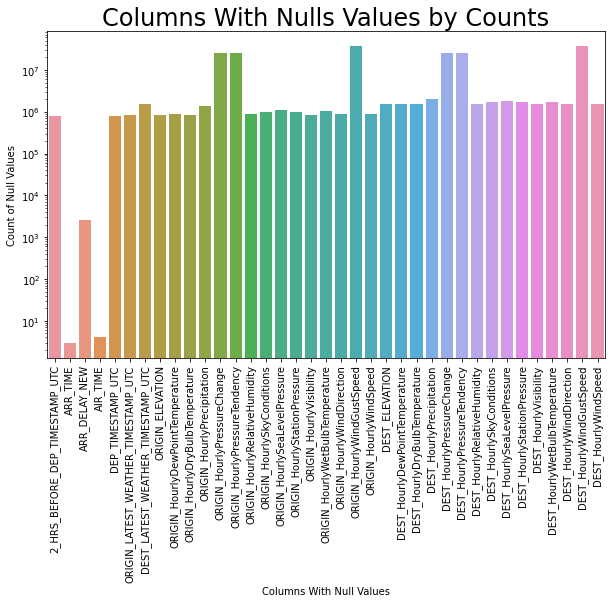

In [ ]:
joined_df = read_joined_data()
missing = check_missing(joined_df)
missing = missing.loc[:, (missing != 0).any(axis=0)]
missing_transposed = missing.T.reset_index()
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.barplot(data=missing_transposed, x='index', y=0, log=True)
plt.xlabel("Columns With Null Values")
plt.ylabel("Count of Null Values")
plt.title( "Columns With Nulls Values by Counts" , size = 24 )
g.tick_params(axis='x', rotation=90)

In [ ]:
def read_joined_data():

    blob_url = write_loc()
    # Read in Joined Data
    joined_df = spark.read.parquet(f"{blob_url}/joined_data_final")

    dropped_cols = ('DEST_STATION_ID', 'ORIGIN_STATION_ID', 'DEST_LAT', 'DEST_LON', 'ORIGIN_LAT', 'ORIGIN_LON', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'ORIGIN_NEIGHBOR_CALL', 'DEST_NEIGHBOR_CALL', 'ORIGIN_TIMEZONE', 'DEST_TIMEZONE', 'LONGITUDE', 'LATITUDE', 'STATION', 'DATE', 'WEATHER_UNIQUE_ID', 'WEATHER_TIMESTAMP', 'WEATHER_TIMEZONE','WEATHER_TIMESTAMP_UTC')

    joined_df = joined_df.drop(*dropped_cols)

    return joined_df

In [ ]:
def convert_type(df,stats):
    for colu in list(df.columns):
        if dict(df.dtypes)[colu] == 'timestamp':
            continue
        elif stats[colu][1] == None:
            df = df.withColumn(colu,col(colu).cast(StringType()))
        else:
            df = df.withColumn(colu,col(colu).cast(FloatType()))
    return df


In [ ]:
def fill_numerical(converted_df):

    for colu in weather_cols:
        wind = (Window
                  .partitionBy(month(converted_df.ORIGIN_LATEST_WEATHER_TIMESTAMP_UTC), dayofmonth(converted_df.ORIGIN_LATEST_WEATHER_TIMESTAMP_UTC))
                  .orderBy("ORIGIN_LATEST_WEATHER_TIMESTAMP_UTC")
                  .rowsBetween(Window.unboundedPreceding, Window.currentRow)
                  )

        result = (converted_df
                    .withColumn(f'{colu}',
                                coalesce(F.col(f'{colu}'), avg(F.col(f'{colu}')).over(wind)))
                    )
    return result

In [ ]:
def fill_cat(df):
    categorical_columns =['2_HRS_BEFORE_DEP_TIMESTAMP_UTC', 'ARR_TIME', 'ARR_DELAY_NEW','AIR_TIME', 'DEP_TIMESTAMP_UTC', 'ORIGIN_LATEST_WEATHER_TIMESTAMP_UTC',
       'DEST_LATEST_WEATHER_TIMESTAMP_UTC']

    for col in categorical_columns:
        df = df.na.fill('Empty',subset=[col])
    return df

In [ ]:
def check_missing(df):

    missing_3 = df.select(*[
      (
          F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
          else F.count(F.when(F.col(c).isNull(), c))
      ).alias(c)
      for c, t in df.dtypes if c in  df.columns
  ]).toPandas()

    return missing_3

In [ ]:
def cleaning_the_data(joined_df):

    stats = joined_df.describe().toPandas()

    #### Convert Data Types

    converted_df = convert_type(joined_df,stats)

    #### Filling the Nulls

    converted_df = fill_numerical(converted_df)
    converted_df = fill_cat(converted_df)

    #### Remove Leftover Nulls

    converted_df_notnull = converted_df.na.drop()

    return converted_df_notnull

### Feature Engineering

There are 4 families of features we leveraged in our models: raw weather numerical features, raw flight numerical features, engineered numerical features and engineered categorical features. Among the engineered feature families, we created various time and graph based features. For example, we engineered time based features to represent the time difference to the latest weather reading at the station nearest by to both the origin and destination airpots. We also engineered graph features to measure the in and out degree for each airport i.e. the number of arriving and departing flights for each airport. We leverage these engineered features in our modeling experiments in order to boost performance.

#### Feature Table (Raw & Engineered)

| Feature Families | Feature | Engineered vs Raw | Description | Data Type | % of Null Values in Original Data | Average
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| Raw Weather Numeric | Origin Hourly Wind Direction | Raw | Wind direction degree near the origin airport | Float | 5.9%  | 171.33  
| Raw Weather Numeric | Dest Hourly Wind Direction | Raw | Wind direction degree near the destination airport | Float | 7.52%  | 172.65
| Raw Weather Numeric | Origin Hourly Wet Bulb Temp | Raw | Wet bulb temp near the origin airport | Float | 2.46%  | 54.1  
| Raw Weather Numeric | Dest Hourly Wet Bulb Temp | Raw | Wet bulb temp near the destination airport | Float | 4.12%  | 54.07
| Raw Weather Numeric | Origin Hourly Station Pressure | Raw | Station pressure near the origin airport | Float |2.43% | 29.12  
| Raw Weather Numeric | Dest Hourly Station Pressure | Raw | Station pressure near the destination airport | Float | 4.09%  | 29.11
| Raw Weather Numeric | Origin Hourly Sea Level Pressure | Raw | Sea level pressure near the origin airport | Float | 2.69% | 30.02  
| Raw Weather Numeric | Dest Hourly Sea Level Pressure | Raw | Sea level pressure near the destination airport | Float | 4.34%  | 30.02
| Raw Weather Numeric | Origin Hourly Relative Humidity | Raw | Relative humidity near the origin airport | Float | 2.08% | 63.87  
| Raw Weather Numeric | Dest Hourly Relative Humidity | Raw | Relative humidity near the destination airport | Float | 3.74%  | 63.7
| Raw Weather Numeric | Origin Hourly Dry Bulb Temp | Raw | Dry bulb temp near the origin airport | Float | 2.08% | 61.71
| Raw Weather Numeric | Dest Hourly Dry Bulb Temp | Raw | Dry bulb temp near the destination airport | Float | 3.74%  | 61.73
| Raw Weather Numeric | Origin Hourly Dew Point Temp | Raw | Dew point temp near the origin airport | Float | 2.11%  | 47.17  
| Raw Weather Numeric | Dest Hourly Dew Point Temp | Raw | Dew point temp near the destination airport | Float | 3.77% | 47.07  
| Raw Weather Numeric | Origin Hourly Precipitation | Raw | Total rainfall near the origin airport | Float | 9.1% | 0.004
| Raw Weather Numeric | Dest Hourly Precipitation | Raw | Total rainfall near the destination airport | Float | 10.6%  | 0.004  
| Raw Weather Numeric | Origin Hourly Visibility | Raw | Total visibility in miles near the origin airport  | Float | 2.1% | 9.400
| Raw Weather Numeric | Dest Hourly Visibility | Raw | Total visibility in miles near the destination airport | Float  | 3.8% |9.403
| Raw Weather Numeric | Origin Hourly Wind Speed | Raw | Sustained wind gust speed near origin airport  | Float | 2.1% | 8.332
| Raw Weather Numeric | Dest Hourly Wind Speed | Raw | Sustained wind gust speed near destination airport | Float | 3.8% | 8.344
| Raw Weather Numeric | Origin Elevation | Raw | Elevation near origin airport | Float | 2.0% | NA
| Raw Weather Numeric | Dest Elevation | Raw | Elevation near destination airport | Float | 3.7% | NA
| Engineered Numeric | Time Diff to Latest Weather Reading at Origin | Engineered | Number of minutes since last weather reading at origin | Float |2.0% | 143.271
| Engineered Numeric | Time Diff to Latest Weather Reading at Dest | Engineered | Number of minutes since last weather reading at dest | Float | 3.7% | 143.288
| Engineered Numeric | Origin Airport Out Degree | Engineered | # of departed flights for the origin airport prior to flight's estimated departure | Float | 0% | 813K
| Engineered Numeric | Dest Airport Out Degree | Engineered | # of departed flights for the destination airport prior to flight's estimated departure  | Float | 0% | 813K
| Engineered Numeric| Origin Airport In Degree | Engineered | # of arrived flights for the origin airport prior to flight's estimated departure  | Float | 0% | 813K
| Engineered Numeric | Dest Airport In Degree | Engineered | # of arrived flights for the destination airport prior to flight's estimated departure  | Float | 0% | 812K
| Engineered Numeric | Plane Previously Delayed  | Engineered | # of minutes tail number from prior flight was delayed |Float | 0.02% | 10.77
| Engineered Numeric | Time Diff to Plane's Prior Flight Arrival  | Engineered | # of minutes ago tail number from prior flight landed |Float | 0.02% | 313.71
| Raw Flight Numeric | Distance | Raw | Distance from origin to destination airport | Float | 0% | 819.62
| Raw Flight Numeric  | Air Time | Raw | Estimated air time for flight | Float | 0% | 113.25
| Engineered Categorical | Departure Day of Week | Engineered | Day of week flight is departing on | String | 0% | -
| Engineered Categorical | Departure Time of Day | Engineered | Time of day (morning, afternoon, evening) flight is departing at | String | 0% | -
| Engineered Categorical | Holiday | Engineered | Indicator of whether flight is scheduled to take off on a bank holiday | Binary | 0% | -

In [ ]:
def create_target_variable(joined_df):

    joined_df = joined_df.withColumn("ARR_DEL30", when(joined_df.ARR_DELAY_NEW >= 30, 1).otherwise(0))

    return joined_df

In [ ]:
def time_last_weather_reading(joined_df):

    # Time Diff to Latest Weather Reading at Origin
    joined_df = joined_df.withColumn("ORIGIN_Weather_Departure_Time_Diff_Sec",col("2_HRS_BEFORE_DEP_TIMESTAMP_UTC").cast("long") - col("ORIGIN_LATEST_WEATHER_TIMESTAMP_UTC").cast("long")).withColumn("ORIGIN_Weather_Departure_Time_Diff_Min",round(col("ORIGIN_Weather_Departure_Time_Diff_Sec")/60))

    # Time Diff to Latest Weather Reading at Dest
    joined_df = joined_df.withColumn("DEST_Weather_Departure_Time_Diff_Sec",col("2_HRS_BEFORE_DEP_TIMESTAMP_UTC").cast("long") - col("DEST_LATEST_WEATHER_TIMESTAMP_UTC").cast("long")).withColumn("DEST_Weather_Departure_Time_Diff_Min",round(col("DEST_Weather_Departure_Time_Diff_Sec")/60))

    return joined_df

In [ ]:
def minutes_delayed(joined_df):

    blob_url = write_loc()

    joined_df = joined_df.withColumn("ARR_TIME", joined_df.ARR_TIME.cast(StringType()))
    joined_df = joined_df.withColumn("ARR_TIME_UPD", when(F.length("ARR_TIME")<4, lpad(joined_df.ARR_TIME, 4, '0')).otherwise(joined_df.ARR_TIME))

    joined_df = joined_df\
      .withColumn("ARR_TIMESTAMP", unix_timestamp(concat(joined_df.FL_DATE, joined_df.ARR_TIME_UPD), "yyyy-MM-ddHHmm")\
      .cast("timestamp"))

    tail_num = joined_df.select("TAIL_NUM", "ARR_TIMESTAMP", "DEST").withColumnRenamed("ARR_TIMESTAMP","TAIL_ARRIVAL_TIME").withColumnRenamed("DEST", "TAIL_ARRIVAL_DEST").withColumnRenamed("TAIL_NUM", "TAIL_NUM_ARRIVAL")


    tail_num_mapping_df = joined_df.join(
        tail_num, joined_df.TAIL_NUM == tail_num.TAIL_NUM_ARRIVAL,
        "left"
    ).groupBy("TAIL_NUM", "DEP_TIMESTAMP").agg(
        F.max(
            F.when(F.col("TAIL_ARRIVAL_TIME") <= F.col("DEP_TIMESTAMP"), F.col("TAIL_ARRIVAL_TIME"))
        ).alias("LATEST_ARRIVAL_TIME"))


    tail_num_mapping_df.write.mode("overwrite").parquet(f"{blob_url}/tailnum_mapping")

In [ ]:
def read_minutes_delayed():

    blob_url = write_loc()
    tail_num_mapping = spark.read.parquet(f"{blob_url}/tailnum_mapping")

    temp1 = joined_df.select('TAIL_NUM', 'ARR_TIMESTAMP', 'ARR_DELAY_NEW').withColumnRenamed("TAIL_NUM", "TAIL_NUM1")
    tail_num_mapping_df = tail_num_mapping.join(temp1, (tail_num_mapping.TAIL_NUM == temp1.TAIL_NUM1) & (tail_num_mapping.LATEST_ARRIVAL_TIME == temp1.ARR_TIMESTAMP))

    tail_num_mapping_df = tail_num_mapping_df.withColumn("Tail_Previous_Arrival_Diff_Sec", col("DEP_TIMESTAMP").cast("long") - col("LATEST_ARRIVAL_TIME").cast("long")).withColumn("Tail_Previous_Arrival_Diff_Mins",round(col("Tail_Previous_Arrival_Diff_Sec")/60))

    temp2 = tail_num_mapping_df.select("TAIL_NUM", "DEP_TIMESTAMP", "Tail_Previous_Arrival_Diff_Mins", "ARR_DELAY_NEW").withColumnRenamed("ARR_DELAY_NEW", "Tail_Previous_Arrival_Delay")
    joined_df = joined_df.join(temp2, ["TAIL_NUM","DEP_TIMESTAMP"], "left")

    joined_df = joined_df.distinct()

    return joined_df

In [ ]:
def departure_day_week(joined_df):
    # Create feature for day of week for estimated departure time
    joined_df = joined_df.withColumn("DEPARTURE_DAY_OF_WEEK", dayofweek(col("DEP_TIMESTAMP")))

    # Create feature for time of day for estimated departure time
    joined_df = joined_df.withColumn("DEPARTURE_HOUR", hour(col("DEP_TIMESTAMP")))
    joined_df = joined_df.withColumn("DEPARTURE_TIME_OF_DAY", F.when((F.col("DEPARTURE_HOUR") >3) & (F.col("DEPARTURE_HOUR") < 11), "Morning"). when((F.col("DEPARTURE_HOUR")>=11) & (F.col("DEPARTURE_HOUR")<17), "Afternoon").otherwise("Evening"))

    return joined_df


In [ ]:
def in_degree_out_degree(joined_df):

    # create feature of in and out degree per airport
    origins = joined_df.select('ORIGIN').withColumnRenamed("ORIGIN", "id").distinct()
    dests = joined_df.select('DEST').withColumnRenamed("DEST", "id").distinct()
    airport_vertices = origins.union(dests)

    degrees_out = joined_df.groupBy("ORIGIN").count().withColumnRenamed("count", "OUT_DEGREE").withColumnRenamed("ORIGIN", "AIRPORT_ID")
    degrees_in = joined_df.groupBy("DEST").count().withColumnRenamed("count", "IN_DEGREE").withColumnRenamed("DEST", "AIRPORT_ID")

    in_out_df = degrees_in.join(degrees_out, ['AIRPORT_ID'], "outer").na.fill(value=0)

    in_out_df = in_out_df.distinct()

    joined_df = joined_df.join(in_out_df, joined_df.ORIGIN == in_out_df.AIRPORT_ID, "left").withColumnRenamed("IN_DEGREE", "ORIGIN_IN_DEGREE").withColumnRenamed("OUT_DEGREE", "ORIGIN_OUT_DEGREE").drop(col("AIRPORT_ID"))

    joined_df = joined_df.join(in_out_df, joined_df.DEST == in_out_df.AIRPORT_ID, "left").withColumnRenamed("IN_DEGREE", "DEST_IN_DEGREE").withColumnRenamed("OUT_DEGREE", "DEST_OUT_DEGREE").drop(col("AIRPORT_ID"))

    joined_df = joined_df.distinct()

    return joined_df

In [ ]:
def holiday_indicator(joined_df):

    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2015-01-01', end='2021-12-31').to_pydatetime()

    holiday_df = spark.createDataFrame(data=holidays, schema = ["holiday"])

    joined_df = joined_df.join(holiday_df, joined_df.DEP_TIMESTAMP_UTC == holiday_df.holiday, "left")
    joined_df = joined_df.withColumn("holiday_indicator", F.when(F.col("holiday").isNull(), 0).otherwise(1))

    return joined_df

In [ ]:
def feature_engineering(joined_df):

    #### Create Target Variable
    joined_df = create_target_variable(joined_df)

    ####  Time to Last Weather Reading
    joined_df = time_last_weather_reading(joined_df)

    #### Plane Previously Delayed and Time Difference to Plane's Prior Arrival Time
    minutes_delayed(joined_df)

    #### Read in Time difference df
    joined_df = read_minutes_delayed()

    #### Departure Time of Day and Departure Day of Week
    joined_df = departure_day_week(joined_df)

    #### In Degree and Out Degree per Airport
    joined_df = in_degree_out_degree(joined_df)

    #### Holiday Indicator
    joined_df = holiday_indicator(joined_df)

    return joined_df

In [ ]:
def final_preprocessing():

    blob_url = write_loc()
    joined_df = read_joined_data()
    joined_df = feature_engineering(joined_df)
    data = cleaning_the_data(joined_df)
    data.write.mode("overwrite").parquet(f"{blob_url}/joined_data_cleaned")

#final_preprocessing()

#### Read In Cleaned Data
The following data was cleaned by filling the nulls and adding new feature engineered columns.

In [ ]:
blob_url = write_loc()
data = spark.read.parquet(f"{blob_url}/joined_data_cleaned")

### Exploratory Data Analysis

We found that many of the numeric features were strongly linearly correlated with each other. For example, distance and air time had a strong positive correlation of 0.98 as expected. However, in general, none of the numeric features had a particularly strong linear relationship with arrival delay, our target variable. One of our engineered features, the plane previously delayed feature, had the strongest correlation with arrival delay of 0.25. All other remaining features had a correlation coefficient near 0.

This correlation analysis has 3 primary implications for modeling:
1. Adding our engineered features to the model, in particular the feature related to the plane previously being delayed, will likely boost performance.
2. Given that none of our features seem to be strongly linearly related to arrival delay, we likely we need to leverage non-linear modeling techniques; logistic regression will likely not perform well here.
3. PCA may be helpful for feature selection. We have a high volume of numeric features (>30), many of them appear to be linearly related to each other, and it's unclear which of them are most important for predicting arrival delay. Thus, using PCA may be helpful for reducing dimensionality while not losing information that may help with the predictive power of our models.

In [ ]:
def corr_matrix(data):

    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=data.columns, outputCol=vector_col)
    df_vector = assembler.transform(data).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

    corr_matrix = matrix.toArray().tolist()
    numeric_variables = data.columns

    corr_matrix_df = pd.DataFrame(data = corr_matrix, columns = numeric_variables, index=numeric_variables)
    return corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
corr_matrix(data.select('DISTANCE', 'AIR_TIME', 'ORIGIN_ELEVATION', 'ORIGIN_HourlyDewPointTemperature', 'ORIGIN_HourlyDryBulbTemperature', 'ORIGIN_HourlyPrecipitation', 'ORIGIN_HourlyRelativeHumidity', 'ORIGIN_HourlySeaLevelPressure', 'ORIGIN_HourlyStationPressure', 'ORIGIN_HourlyVisibility', 'ORIGIN_HourlyWetBulbTemperature', 'ORIGIN_HourlyWindDirection', 'ORIGIN_HourlyWindSpeed', 'DEST_ELEVATION', 'DEST_HourlyDewPointTemperature', 'DEST_HourlyDryBulbTemperature', 'DEST_HourlyPrecipitation', 'DEST_HourlyRelativeHumidity', 'DEST_HourlySeaLevelPressure', 'DEST_HourlyStationPressure', 'DEST_HourlyVisibility', 'DEST_HourlyWetBulbTemperature', 'DEST_HourlyWindDirection', 'DEST_HourlyWindSpeed', 'ARR_DELAY_NEW'))

<command-1215577238255373>:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,DISTANCE,AIR_TIME,ORIGIN_ELEVATION,ORIGIN_HourlyDewPointTemperature,ORIGIN_HourlyDryBulbTemperature,ORIGIN_HourlyPrecipitation,ORIGIN_HourlyRelativeHumidity,ORIGIN_HourlySeaLevelPressure,ORIGIN_HourlyStationPressure,ORIGIN_HourlyVisibility,ORIGIN_HourlyWetBulbTemperature,ORIGIN_HourlyWindDirection,ORIGIN_HourlyWindSpeed,DEST_ELEVATION,DEST_HourlyDewPointTemperature,DEST_HourlyDryBulbTemperature,DEST_HourlyPrecipitation,DEST_HourlyRelativeHumidity,DEST_HourlySeaLevelPressure,DEST_HourlyStationPressure,DEST_HourlyVisibility,DEST_HourlyWetBulbTemperature,DEST_HourlyWindDirection,DEST_HourlyWindSpeed,ARR_DELAY_NEW
DISTANCE,1.00,0.98,-0.07,0.02,0.02,-0.00,0.00,-0.03,0.06,0.00,0.03,0.00,0.02,-0.07,0.02,0.03,-0.00,0.00,-0.03,0.06,0.01,0.03,0.01,0.03,0.01
AIR_TIME,0.98,1.00,-0.09,0.01,0.01,0.00,0.01,-0.02,0.09,-0.00,0.01,0.01,0.03,-0.06,0.02,0.02,0.00,0.00,-0.04,0.05,-0.00,0.02,0.01,0.03,0.02
ORIGIN_ELEVATION,-0.07,-0.09,1.00,-0.32,-0.13,-0.02,-0.29,-0.12,-0.99,0.03,-0.25,-0.00,0.02,0.16,-0.06,-0.02,-0.01,-0.05,-0.03,-0.17,0.01,-0.05,-0.00,-0.01,-0.01
ORIGIN_HourlyDewPointTemperature,0.02,0.01,-0.32,1.00,0.77,0.07,0.43,-0.29,0.28,-0.05,0.94,-0.12,-0.09,-0.06,0.55,0.53,0.03,0.10,-0.24,0.03,0.02,0.57,-0.05,-0.05,0.03
ORIGIN_HourlyDryBulbTemperature,0.02,0.01,-0.13,0.77,1.00,-0.00,-0.21,-0.40,0.08,0.14,0.94,-0.05,0.02,-0.02,0.52,0.63,0.01,-0.09,-0.27,-0.01,0.08,0.61,-0.01,0.04,0.03
ORIGIN_HourlyPrecipitation,-0.00,0.00,-0.02,0.07,-0.00,1.00,0.14,-0.06,0.01,-0.29,0.04,-0.02,0.04,-0.01,0.03,0.02,0.02,0.02,-0.02,0.01,-0.02,0.02,-0.00,0.01,0.05
ORIGIN_HourlyRelativeHumidity,0.00,0.01,-0.29,0.43,-0.21,0.14,1.00,0.06,0.28,-0.36,0.12,-0.14,-0.21,-0.05,0.11,-0.08,0.02,0.31,-0.01,0.05,-0.10,0.02,-0.07,-0.14,0.01
ORIGIN_HourlySeaLevelPressure,-0.03,-0.02,-0.12,-0.29,-0.40,-0.06,0.06,1.00,0.25,0.05,-0.36,-0.11,-0.19,-0.03,-0.24,-0.27,-0.02,-0.00,0.51,0.10,-0.00,-0.27,-0.06,-0.05,-0.04
ORIGIN_HourlyStationPressure,0.06,0.09,-0.99,0.28,0.08,0.01,0.28,0.25,1.00,-0.01,0.21,-0.02,-0.04,-0.17,0.03,-0.01,0.01,0.05,0.10,0.18,-0.01,0.02,-0.01,0.00,0.00
ORIGIN_HourlyVisibility,0.00,-0.00,0.03,-0.05,0.14,-0.29,-0.36,0.05,-0.01,1.00,0.05,0.08,0.05,0.01,0.02,0.07,-0.02,-0.10,-0.00,-0.00,0.10,0.05,0.02,0.02,-0.05


In [ ]:
corr_matrix(data.select('ORIGIN_Weather_Departure_Time_Diff_Min', 'DEST_Weather_Departure_Time_Diff_Min', 'Tail_Previous_Arrival_Diff_Mins', 'Tail_Previous_Arrival_Delay', 'ORIGIN_IN_DEGREE', 'ORIGIN_OUT_DEGREE', 'ARR_DELAY_NEW'))

<command-1215577238255373>:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,ORIGIN_Weather_Departure_Time_Diff_Min,DEST_Weather_Departure_Time_Diff_Min,Tail_Previous_Arrival_Diff_Mins,Tail_Previous_Arrival_Delay,ORIGIN_IN_DEGREE,ORIGIN_OUT_DEGREE,ARR_DELAY_NEW
ORIGIN_Weather_Departure_Time_Diff_Min,1.00,1.00,0.00,-0.03,0.01,0.01,-0.01
DEST_Weather_Departure_Time_Diff_Min,1.00,1.00,0.00,-0.03,0.01,0.01,-0.01
Tail_Previous_Arrival_Diff_Mins,0.00,0.00,1.00,0.01,0.00,0.00,0.01
Tail_Previous_Arrival_Delay,-0.03,-0.03,0.01,1.00,0.00,0.00,0.25
ORIGIN_IN_DEGREE,0.01,0.01,0.00,0.00,1.00,1.00,-0.00
ORIGIN_OUT_DEGREE,0.01,0.01,0.00,0.00,1.00,1.00,-0.00
ARR_DELAY_NEW,-0.01,-0.01,0.01,0.25,-0.00,-0.00,1.00


When looking at the distribution of flight delays by year, we see that there are slightly fewer overall flights in 2020 and a smaller portion of them that were delayed likely driven by the pandemic. In 2021, the volume of flights seemed to rebound to prior levels and we saw a similar proportion of flights be delayed as we had in prior years (~10%).

In [ ]:
data = data.withColumn("YEAR", year(data.DEP_TIMESTAMP))
counts_v1 = data.groupby("YEAR", "ARR_DEL30").count().orderBy("YEAR", "ARR_DEL30")
display(counts_v1)

YEAR,ARR_DEL30,count
2015,0.0,3840524
2015,1.0,459341
2016,0.0,3741986
2016,1.0,423828
2017,0.0,3744420
2017,1.0,460842
2018,0.0,4653094
2018,1.0,593259
2019,0.0,4641082
2019,1.0,608246


Output can only be rendered in Databricks

# Modeling

In order to conduct our modeling, we leveraged data from years 2015 - 2020 as our training set and 2021 as our test set. We used time sensitive cross validation, in which each fold included the additional subsequent with year. Our overall modeling journey involved developing a simple logistic regression baseline to ground ourselves in a benchmark. We immediately saw from our baseline model that there was room for improvement. We explored two different feature selection approaches in order to improve upon the baseline: PCA and selection based on pearson correlations. We then leveraged these refined features in decision tree, random forest and neural network models. Each model seemed to have strengths and weaknesses. The decision tree had higher recall (0.42) and was therefore able to identify more delayed flights. The random forest model had higher precision (0.86) and therefore more of the flights it flagged as delayed were actually delayed. The neural network performed worse than both the decision tree and random forest models but still demonstrated some predictive power (AUC of 0.6). In order to combine the predictive power of each model, we ensembled the decision tree, random forest and neural network models together. We took the maximum prediction from each in order to try to maximize our ability to identify delayed flights. The final ensemble model performed the best on the whole as it was able to exceed our overall predictive power target with an AUC score of 0.64 while balancing recall (0.59) and precision (0.62).

**Modeling process:**<br><br>

1. Baseline Model
2. PCA - Feature Selection
3. Decision Tree
4. Random Forest
5. Neural Network
6. Ensemble

## Modeling Overview and Results

**Train:** Years 2015 - 2020 \
\
**Validation:** Time Sensitive cross fold validation \
Fold 1: train on 2015, test on 2016 \
Fold 2: train on 2015-2016, test on 2017 \
Fold 3: train on 2015 - 2017, test on 2018 \
Fold 4: train on 2015 - 2018, test on 2019 \
Fold 5: train on 2015 - 2019, test on 2020 \
\
**Test:** Year 2021

**Cluster Size:**
Standard 16GB 4 cores

**Feature Families:**
| Family | Description | Count of Features
| ----------- | ----------- | ----------- |
| Raw Flight Numerical | Raw numerical flight variables that were most highly correlated with arrival delay and not correlated with each other (distance and air time were the only 2 and they were highly correlated with each other so distance was selected)  | 1
| Raw Weather Numerical | Raw numerical weather variables that were most highly correlated with arrival delay and not correlated with each other | 14
| Engineered Numerical  | Engineered numerical features | 6
| Engineered Categorical | Engineered categorical features | 3
| PCA Features | Principal components from PCA analysis | 24

**Experiment Table**

| Model | Experiment | Feature Families  | Train AUC | Test AUC | Train Recall | Test Recall | Train Precision | Test Precision | Training Time | Hyperparameters
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |----------- | ----------- |----------- | ----------- | ----------- |
| Logistic Regression | Baseline | Raw Weather Numerical + Raw Flight Numerical |  0.55 | 0.54 | - | - | - | - | ~34 min | -
| Random Forest | Experiment #2.1 | Raw Flight Numerical + Raw Weather Numerical| 0.85 | 0.86 | 0.0007 | 0.003 | 0.81 | 0.81 | ~9 min | Max Depth = 10, Num Trees = 15
| Random Forest | Experiment #2.2 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical| 0.85 | 0.85 | 0.002 | 0.02 | 0.8 | 0.81 | ~6 min | Max Depth = 10, Num Trees = 15
| Random Forest | Experiment #2.3 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with undersampling | 0.7 | 0.74| 0.12 | 0.37 | 0.85 | 0.85 | ~2 min | Max Depth = 10, Num Trees = 15
| Random Forest | Experiment #2.4 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with oversampling|  0.69 | 0.74| 0.06 | 0.38 | 0.83 | 0.86 | ~13 min | Max Depth = 10, Num Trees = 15
| Decision Tree | Experiment #3.1 | Raw Flight Numerical + Raw Weather Numerical| 0.68 | 0.55 | 0.0003 | 0.000005 | 0.46 | 0.2 | ~10 min | Max Depth = 5
| Decision Tree | Experiment #3.2 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical| 0.76 | 0.83 | 0.002 | 0.035 | 0.62 | 0.77 | ~5 min | Max Depth = 5
| Decision Tree | Experiment #3.3 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with undersampling|  0.74 | 0.72| 0.002 | 0.06 | 0.58 | 0.72 | ~11 min | Max Depth = 5
| Decision Tree | Experiment #3.4 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with oversampling|  0.67 | 0.72| 0.17 | 0.42 | 0.78 | 0.81 | ~11 min | Max Depth = 5
| Neural Network | Experiment #4.1 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with undersampling | 0.59 | 0.6| 0.04 | 0.14 | 0.29 | 0.30 | ~3 min | MLP - Relu - 2 Softmax, Hidden Layers: [4, 5]
| Neural Network | Experiment #4.2 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with undersampling | 0.62 | 0.61| 0.12 | 0.18 | 0.35 | 0.32 | ~3 min | MLP - Relu - 2 Softmax, Hidden Layers: [10, 10]
| Ensemble | Final Model | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with undersampling | 0.58 | 0.64| 0.26 | 0.59 | 0.57 | 0.62 | ~1 hr | Random Forest: Max Depth = 10, Num Trees = 15, Decision Tree: Max Depth = 5, MLP - Relu - 2 Softmax, Hidden Layers: [10, 10]

### Feature Selection - PCA

In order to perform feature selection, we first leveraged PCA. From our EDA we saw that there are a large volume of numerical features and many of them are linearly correlated with each other. PCA would allow us to reduce dimensionality while maintaining the most important, predictive components of the various features. However, after completing PCA we found that ~25 out of the ~30 features were required in order to explain the majority of the variance. Given that PCA would not allow us to reduce dimensionality in a meaningful way and would also lead to less interpretable results, we instead decided to select features based on our correlation matrix and use the features themselves in our modeling. We removed ~10 features based on their high collinearity with another feature and low correlation with our target variable. This left us with ~25 features for modeling.

In [ ]:
def pca_function(data):

    w = Window().orderBy(lit('A'))
    data = data.withColumn("uniqueID", row_number().over(w))

    # Train / Test Split
    train_pca = data.filter(F.year(data.DEP_TIMESTAMP) <= 2020)
    test_pca =  data.filter(F.year(data.DEP_TIMESTAMP) > 2020)

    # define numeric columns
    numericCols=['uniqueID', 'DISTANCE', 'AIR_TIME', 'ORIGIN_ELEVATION', 'ORIGIN_HourlyDewPointTemperature', 'ORIGIN_HourlyDryBulbTemperature', 'ORIGIN_HourlyPrecipitation', 'ORIGIN_HourlyRelativeHumidity', 'ORIGIN_HourlySeaLevelPressure', 'ORIGIN_HourlyStationPressure', 'ORIGIN_HourlyVisibility', 'ORIGIN_HourlyWetBulbTemperature', 'ORIGIN_HourlyWindDirection', 'ORIGIN_HourlyWindSpeed', 'DEST_ELEVATION', 'DEST_HourlyDewPointTemperature', 'DEST_HourlyDryBulbTemperature', 'DEST_HourlyPrecipitation', 'DEST_HourlyRelativeHumidity', 'DEST_HourlySeaLevelPressure', 'DEST_HourlyStationPressure', 'DEST_HourlyVisibility', 'DEST_HourlyWetBulbTemperature', 'DEST_HourlyWindDirection', 'DEST_HourlyWindSpeed', 'ORIGIN_Weather_Departure_Time_Diff_Min', 'DEST_Weather_Departure_Time_Diff_Min', 'Tail_Previous_Arrival_Diff_Mins', 'Tail_Previous_Arrival_Delay', 'ORIGIN_IN_DEGREE', 'ORIGIN_OUT_DEGREE', 'DEST_IN_DEGREE', 'DEST_OUT_DEGREE']


    # create df with only numeric columns
    df_numeric=data.select(*numericCols)
    df_numeric_train=train_pca.select(*numericCols)
    df_numeric_test=test_pca.select(*numericCols)

    assembler = VectorAssembler(inputCols=numericCols, outputCol='features')

    # standardize the full df
    df_numeric = assembler.transform(df_numeric)
    ss = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures', withMean = True, withStd = True).fit(df_numeric)
    df_numeric_scaled=ss.transform(df_numeric)

    # standardize the train df
    #assember_train=VectorAssembler(inputCols=numericCols, outputCol='features')
    df_numeric_train=assembler.transform(df_numeric_train)
    ss_train = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures', withMean = True, withStd = True).fit(df_numeric_train)
    df_numeric_train_scaled=ss_train.transform(df_numeric_train)

    # standardize the test df
    #assember_test=VectorAssembler(inputCols=numericCols, outputCol='features')
    df_numeric_test=assembler.transform(df_numeric_test)
    ss_test = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures', withMean = True, withStd = True).fit(df_numeric_test)
    df_numeric_test_scaled=ss.transform(df_numeric_test)

    # run PCA with "30" to see the explained variance of all the generated components, before deciding what is the right number
    pca = PCA(k=30, inputCol="scaledFeatures", outputCol="pcaScaledFeatures")
    pcaModel=pca.fit(df_numeric_scaled) # fit with full df
    cumValues = pcaModel.explainedVariance.cumsum() # get the cumulative values

    return cumValues

Out[118]: Text(0, 0.5, 'cumulative explained variance')

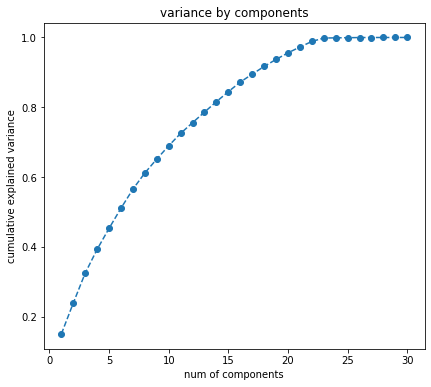

In [ ]:
cumValues = pca_function(data)
# plot the graph
plt.figure(figsize=(15,6))
p = plt.subplot(1, 2, 1)
p.plot(range(1,31), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')

### Models

## Baseline Logistic Regression

Our baseline model was logistic regression. We chose logistic regression with no regularization. The loss function for logistic regression is Log Loss: \\( L(Y,Y')= \sum^N_{i=1} log( 1+ exp(-y_i, yhat_i))\\). We chose it mainly for its easy implementation. We ran 3 experiments on the joined data. For the baseline models, we only used the weather and flight data to map out our pipeline and get a working baseline model. For our weather family, we use two features: hourly precipitation and origin elevation. For our flight data, we also use two features: flight distance and airtime of flight. We used these features for their uniqueness and ability to clean and investigate while parallel exploratory data analysis was ongoing. Our response variable is Arrival Delay. We classify a flight as delayed if it is more than 30 minutes later than expected. We used this threshold because it gave us a wider distribution of quantity of classes in our data, but because the transportation adminstration uses this metric for it. After running logistic regression, we found the performance to be poor, so after consideration we stopped expanding on it. The performance was poor because the feature variables had issues of multicollinearity.

## Decision Tree

From logistic regression, we moved to decision trees as a classfier model. We chose this because of our analysis on the features with multicollinearity. Also a linear model was not the most appropriate given our data analysis. Considering these ideas, we chose decision trees because it was a robust classifier to fit a non linear boundary to predict whether flights were delayed. We had to consider overfitting with decision trees since they are more susceptible to overfitting, and we thought we would counteract this with pruning and setting max depth to avoid specific pathways.

Decision trees are not differentiable, and they do not use gradient descent, so they do not have a loss function.
Decision trees typically use gini impurity, entropy and information gain to select the best way to branch from each node in the tree given the training data. Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset. When training a decision tree, the best split is chosen by maximizing the Gini Gain, which is calculated by subtracting the weighted impurities of the branches from the original impurity. Gini impuruty and entropy are both impurities used for classification. Gini Impurity is \\(  \sum^C_{i=1} f_i( 1 - f_i)\\) and entropy is \\(  \sum^C_{i=1} -f_i log(f_i)\\) where f is the frequency of label i at a node and C is the number of unique labels. The information gain is the difference between the parent node impurity and the weighted sum of the two child node impurities.

In our model, we use all the numerical and categorical features for our decision tree classifier and used grid search for the max depth of trees to prevent overfitting. Otherwise it will use another stopping rule where there is no information gain or no child node can be produced.

## Random Forest

Our next model was a random forest. We chose this model as it was a natural progression from decision trees since random forests are ensembles of decision trees. They combine many decision trees and average the results to avoid overfiting. Like decision trees, we chose them because of their ability to fit non linear models and handle categorical and numerical features well. Here we use it for binary classification with the same output variable as decision trees and logistic regression (delay of flight is 30 minutes past estimated arrival).

Here we used hyperparameters for number of trees and maximum depth for trees and used grid search to find the optimal parameters in our experiments with both numerical and categorical features. Random forests incorporate randomness by subsampling the original dataset natively and considers random splits along the way. Apart from these differences, the process is the same as decision trees.

## Neural Network

From random forests, we turned to neural networks, specifically multilayer perceptron classifier. The multilayer perceptron classifier (MLPC) is a classifier based on the feedforward artificial neural network that consists of multiple layers of nodes. Each layer is fully connected to the next layer in the network. Nodes in the input layer represent the input data. These inputs are passed to hidden layers with a linear combination of the inputs with the node’s weights and biases along with an activation function. This is proprogated further till the output until the error is propogated back. We use softmax for our output layer to classify our binary classifcation of flight delays \\( f(z_i)=e^{z_i}/(∑^N_{k=1}e^{z_k}) \\). Our activation function is rectified linear unit which is advantageous over sigmoid or tan functions because it has a reduced likelihood of vanishing gradient which results in faster training. We used two hidden layers with 10 nodes in each layer for one experiment and one experiment with 4 and 5 layers.



## Ensemble

Once we had our decision tree, random forest and neural network models, we combined them into one ensemble by simply using the max of the prediction values to predict our final output decision. We did this because our original models tended to underpredict the positive class, so we wanted to use an ensemble to improve recall and precision.

In [ ]:
%run "/Shared/custom_cv"

In [ ]:
def one_hot_encoding_pipeline(model_type):

    categoricals = ['DEPARTURE_DAY_OF_WEEK', 'DEPARTURE_TIME_OF_DAY', 'holiday_indicator']

    numerics = ['DISTANCE', 'ORIGIN_ELEVATION', 'ORIGIN_HourlyDryBulbTemperature', 'ORIGIN_HourlyPrecipitation', 'ORIGIN_HourlySeaLevelPressure', 'ORIGIN_HourlyVisibility', 'ORIGIN_HourlyWindDirection', 'ORIGIN_HourlyWindSpeed', 'DEST_ELEVATION', 'DEST_HourlyDryBulbTemperature', 'DEST_HourlyPrecipitation', 'DEST_HourlySeaLevelPressure', 'DEST_HourlyVisibility', 'DEST_HourlyWindDirection', 'DEST_HourlyWindSpeed', 'ORIGIN_Weather_Departure_Time_Diff_Min','DEST_Weather_Departure_Time_Diff_Min', 'Tail_Previous_Arrival_Diff_Mins', 'Tail_Previous_Arrival_Delay', 'ORIGIN_IN_DEGREE', 'ORIGIN_OUT_DEGREE', 'DEST_IN_DEGREE','DEST_OUT_DEGREE']

    # One Hot Encoding of categorical variables
    indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'skip'), categoricals)
    ohes = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"),categoricals)

    # Create features list
    featureCols = list(map(lambda c: c+"_class", categoricals)) + numerics

    model_matrix_stages = list(indexers) + list(ohes) + \
                         [VectorAssembler(inputCols=featureCols, outputCol="features"), StringIndexer(inputCol="ARR_DEL30", outputCol="label")]

    if model_type == 'random':
        trainer = RandomForestClassifier(labelCol='label', featuresCol='features')

        pipeline = Pipeline(stages=model_matrix_stages+[trainer])

        # Build the parameter grid for model tuning
        paramGrid = ParamGridBuilder() \
                      .addGrid(trainer.maxDepth, [5, 10]) \
                      .addGrid(trainer.numTrees, [10, 15]) \
                      .build()
    elif model_type == 'decision':
        trainer = DecisionTreeClassifier(labelCol="label", featuresCol="features")


        pipeline = Pipeline(stages=model_matrix_stages+[trainer])

        # Build the parameter grid for model tuning
        paramGrid = ParamGridBuilder()\
                        .addGrid(trainer.maxDepth, [5, 10, 15, 20])\
                        .build()
    else:
        featureCols = numerics

        model_matrix_stages = [VectorAssembler(inputCols=featureCols, outputCol="features"), StringIndexer(inputCol="ARR_DEL30", outputCol="label")]


        # Apply StandardScaler to create scaledFeatures
        scaler = StandardScaler(inputCol="features",
                                outputCol="scaledFeatures",
                                withStd=True,
                                withMean=True)

        layers = [len(featureCols), 10, 10, 2]

        trainer = MultilayerPerceptronClassifier(labelCol='label',
                                                    featuresCol='scaledFeatures',
                                                    maxIter=100,
                                                    layers=layers,
                                                    blockSize=128,
                                                    seed=1234)

        # Build our ML pipeline
        pipeline = Pipeline(stages=model_matrix_stages+[scaler]+[trainer])

        # Build the parameter grid for model tuning
        paramGrid = ParamGridBuilder() \
                      .addGrid(trainer.maxIter, [10]) \
                      .addGrid(trainer.stepSize, [0.3]) \
                      .build()

    return pipeline, paramGrid

In [ ]:
def model(data, model_type):

    evaluator = BinaryClassificationEvaluator()

    pipeline, paramGrid = one_hot_encoding_pipeline(model_type)
    dt = pipeline
    grid = paramGrid

    major_df = data.filter(col("ARR_DEL30") == 0)
    minor_df = data.filter(col("ARR_DEL30") == 1)
    ratio = int(major_df.count()/minor_df.count())
    sampled_majority_df = major_df.sample(False, 1/ratio)
    undersampled_data = sampled_majority_df.unionAll(minor_df)

    dt_input = undersampled_data

    dt_input = dt_input.withColumn("YEAR", year(dt_input.DEP_TIMESTAMP))
    dt_input.select("DEP_TIMESTAMP", "YEAR").show(5)
    dt_input_val = dt_input.filter(F.year(dt_input.DEP_TIMESTAMP) <= 2020)
    # create dictionary of dataframes for custom cv fn to loop through
    # assign train and test based on time series split
    # train: month 1, months 1 & 2, test: month 2, month 3
    d = {}

    d['df1'] = dt_input_val.filter(dt_input_val.YEAR <= 2016)\
                       .withColumn('cv', F.when(dt_input_val.YEAR == 2015, 'train')
                                             .otherwise('test'))

    d['df2'] = dt_input_val.filter(dt_input_val.YEAR <= 2017)\
                       .withColumn('cv', F.when(dt_input_val.YEAR <= 2016, 'train')
                                             .otherwise('test'))

    d['df3'] = dt_input_val.filter(dt_input_val.YEAR <= 2018)\
                       .withColumn('cv', F.when(dt_input_val.YEAR <= 2017, 'train')
                                             .otherwise('test'))

    d['df4'] = dt_input_val.filter(dt_input_val.YEAR <= 2019)\
                       .withColumn('cv', F.when(dt_input_val.YEAR <= 2018, 'train')
                                             .otherwise('test'))

    d['df5'] = dt_input_val.filter(dt_input_val.YEAR <= 2020)\
                       .withColumn('cv', F.when(dt_input_val.YEAR <= 2019, 'train')
                                             .otherwise('test'))
    # run cross validation & return the crossvalidation F0.5 score for 'test' set
    cv = CustomCrossValidator(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator,
         splitWord = ('train', 'test'), cvCol = 'cv', parallelism=4)

    cvModel = cv.fit(d)

    train = dt_input.filter(F.year(dt_input.DEP_TIMESTAMP) <= 2020)

    test =  dt_input.filter(F.year(dt_input.DEP_TIMESTAMP) > 2020)

    train_predictions = cvModel.transform(train)
    train_confusion_matrix = train_predictions.groupby('label', 'prediction').count()
    TP = train_confusion_matrix.select('count').filter((train_confusion_matrix.label==1) & (train_confusion_matrix.prediction==1)).collect()[0][0]
    FP = train_confusion_matrix.select('count').filter((train_confusion_matrix.label==0) & (train_confusion_matrix.prediction==1)).collect()[0][0]
    FN = train_confusion_matrix.select('count').filter((train_confusion_matrix.label==1) & (train_confusion_matrix.prediction==0)).collect()[0][0]

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    print('Train AUC:', BinaryClassificationMetrics(train_predictions['label','prediction'].rdd).areaUnderROC)
    print('Train Precision: ', float(TP / (TP + FP)))
    print('Train Recall: ', float(TP / (TP + FN)))

    test_predictions = cvModel.transform(test)
    test_confusion_matrix = test_predictions.groupby('label', 'prediction').count()
    TP = test_confusion_matrix.select('count').filter((test_confusion_matrix.label==1) & (test_confusion_matrix.prediction==1)).collect()[0][0]
    FP = test_confusion_matrix.select('count').filter((test_confusion_matrix.label==0) & (test_confusion_matrix.prediction==1)).collect()[0][0]
    FN = test_confusion_matrix.select('count').filter((test_confusion_matrix.label==1) & (test_confusion_matrix.prediction==0)).collect()[0][0]

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    print('Test AUC:', BinaryClassificationMetrics(test_predictions['label','prediction'].rdd).areaUnderROC)
    print('Test Precision: ', float(TP / (TP + FP)))
    print('Test Recall: ', float(TP / (TP + FN)))

#     print('maxDepth - ', cvModel.bestModel.getOrDefault('maxDepth'))

    return train_predictions, test_predictions

In [ ]:
def ensemble():

    train_predictions_random, test_predictions_random = model(data, 'random')
    train_predictions_decision, test_predictions_decision = model(data, 'decision')
    train_predictions_neural, test_predictions_neural = model(data, 'neural')

    train_predictions_random = train_predictions_random.withColumnRenamed("prediction", "prediction_random")
    train_predictions_decision = train_predictions_decision.withColumnRenamed("prediction", "prediction_decision").drop("label")
    train_predictions_neural = train_predictions_neural.withColumnRenamed("prediction", "prediction_neural").drop("label")

    w = Window().orderBy(lit('A'))
    train_predictions_random = train_predictions_random.withColumn("index", row_number().over(w))
    train_predictions_decision = train_predictions_decision.withColumn("index", row_number().over(w))
    train_predictions_neural = train_predictions_neural.withColumn("index", row_number().over(w))

    ensemble_preds = train_predictions_random.join(train_predictions_decision, ["index"], "inner").join(train_predictions_neural, ["index"], "inner")

    minf = lit(float("-inf"))
    rowmax = greatest(*[coalesce(col(x), minf) for x in ['prediction_random','prediction_decision','prediction_neural']])
    ensemble_preds = ensemble_preds.withColumn("rowmax", rowmax)

    train_confusion_matrix = ensemble_preds.groupby('label', 'rowmax').count()
    TP = train_confusion_matrix.select('count').filter((train_confusion_matrix.label==1) & (train_confusion_matrix.rowmax==1)).collect()[0][0]
    FP = train_confusion_matrix.select('count').filter((train_confusion_matrix.label==0) & (train_confusion_matrix.rowmax==1)).collect()[0][0]
    FN = train_confusion_matrix.select('count').filter((train_confusion_matrix.label==1) & (train_confusion_matrix.rowmax==0)).collect()[0][0]

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    print('Train AUC:', BinaryClassificationMetrics(ensemble_preds['label','rowmax'].rdd).areaUnderROC)
    print('Train Precision: ', float(TP / (TP + FP)))
    print('Train Recall: ', float(TP / (TP + FN)))


    test_predictions_random = test_predictions_random.withColumnRenamed("prediction", "prediction_random")
    test_predictions_decision = test_predictions_decision.withColumnRenamed("prediction", "prediction_decision").drop("label")
    test_predictions_neural = test_predictions_neural.withColumnRenamed("prediction", "prediction_neural").drop("label")

    test_predictions_random = test_predictions_random.withColumn("index", row_number().over(w))
    test_predictions_decision = test_predictions_decision.withColumn("index", row_number().over(w))
    test_predictions_neural = test_predictions_neural.withColumn("index", row_number().over(w))

    ensemble_preds = test_predictions_random.join(test_predictions_decision, ["index"], "inner").join(test_predictions_neural, ["index"], "inner")

    minf = lit(float("-inf"))
    rowmax = greatest(*[coalesce(col(x), minf) for x in ['prediction_random','prediction_decision','prediction_neural']])
    ensemble_preds = ensemble_preds.withColumn("rowmax", rowmax)

    test_confusion_matrix = ensemble_preds.groupby('label', 'rowmax').count()
    TP = test_confusion_matrix.select('count').filter((test_confusion_matrix.label==1) & (test_confusion_matrix.rowmax==1)).collect()[0][0]
    FP = test_confusion_matrix.select('count').filter((test_confusion_matrix.label==0) & (test_confusion_matrix.rowmax==1)).collect()[0][0]
    FN = test_confusion_matrix.select('count').filter((test_confusion_matrix.label==1) & (test_confusion_matrix.rowmax==0)).collect()[0][0]

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    print('Test AUC:', BinaryClassificationMetrics(ensemble_preds['label','rowmax'].rdd).areaUnderROC)
    print('Test Precision: ', float(TP / (TP + FP)))
    print('Test Recall: ', float(TP / (TP + FN)))

    return ensemble_preds

In [ ]:
ensemble()

+-------------------+----+
|      DEP_TIMESTAMP|YEAR|
+-------------------+----+
|2015-02-07 21:40:00|2015|
|2015-02-07 19:55:00|2015|
|2015-02-07 21:55:00|2015|
|2015-02-07 21:55:00|2015|
|2015-02-07 22:00:00|2015|
+-------------------+----+
only showing top 5 rows

fold 1 start...
fold 1 end
fold 2 start...
fold 2 end
fold 3 start...
fold 3 end
fold 4 start...
fold 4 end
fold 5 start...
fold 5 end
Best Model:  {Param(parent='RandomForestClassifier_6511ceae839c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='RandomForestClassifier_6511ceae839c', name='numTrees', doc='Number of trees to train (>= 1).'): 15} Detailed Score [0.8067543201422374, 0.8066673598619243, 0.8074317639350823, 0.8060405275069715, 0.7544992619975015] Avg Score 0.7962786466887434
Train AUC: 0.7003367575633116
Train Precision:  0.8529066972531226
Train Recall:  0.11104079840745996
Te

### Testing on 2018 - 2020

Despite meeting our overall goals, our model did not have as high predictive power and thus we went back and tried testing on the years 2018 - 2020 as opposed to 2021 in order to see how the performance compared. We used our best performing Random Forest model for these experiments as opposed to the ensemble in order to optimize for efficiency and obtain quick insights. We found that our model performed much better when tested on years 2018 - 2020 with a test AUC of ~0.74, recall of 0.8 and precision of 0.7. From our EDA, we know that there is not a large difference in the distribution or volume of delayed flights in 2021. Thus, this suggests that 2021 introduced a new volatility regime; the features that were able to predict flight delays in 2015 - 2020 are no longer as strong in predicting delays in 2021.

**Experiment Table**

| Model | Experiment |Feature Families | Train / Test Split | Train AUC | Test AUC | Train Recall | Test Recall | Train Precision | Test Precision | Training Time | Hyperparameters
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |----------- | ----------- |----------- | ----------- | ----------- | ----------- |
| Random Forest | Experiment #5.1 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with undersampling | Train: 2015 - 2019, Test: 2020| 0.74 | 0.67| 0.79 | 0.78 | 0.72 | 0.80 | ~14 min | Max Depth = 10, Num Trees = 15
| Random Forest | Experiment #5.2 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with undersampling | Train: 2015 - 2018, Test: 2019| 0.74 | 0.74 | 0.80 | 0.80 | 0.72 | 0.70 | ~13 min | Max Depth = 10, Num Trees = 15
| Random Forest | Experiment #5.3 | Raw Flight Numerical + Raw Weather Numerical + Engineered Numerical with undersampling | Train: 2015 - 2017, Test: 2018| 0.74 | 0.74| 0.68 | 0.67 | 0.77 | 0.78 | ~3 min | Max Depth = 10, Num Trees = 15

#Results & Findings

### Discussion of Results & Gap Analysis
We were able to meet our objective of building a relatively predictive model (AUC > 0.60) that balances both recall and precision and thus the ability to identify the majority of delayed flights as delayed while also not overflagging delayed flights that are not truly delayed. Our final model was an ensemble of a random forest, decision tree and neural network, taking the maximum prediction across these 3 models. When testing on flights in 2021, this final model had a test AUC of 0.64 suggesting that there is a 64% chance our model can distinguish between delayed and not delayed flights. When making this distinction, our model is able to identify ~59% of flights that are delayed as delayed. When it flags a flight as delayed, there is a 62% chance the flight is actually delayed.

Amongst the features explored for our models, we found that a plane's previous flight arrival delay is important in predicting whether or not it is delayed on its next leg. This was supported by linear correlation with arrival delay that was 20% higher than any of the other features explored. In addition, when adding this variable and the other engineered numerical variables to our random forest models, we saw a boost in recall from 0.003 to 0.02 from experiments 2.1 to 2.2. Similarly, when adding this variable and the other engineered numerical variables to our decision tree we saw a boost in performance across AUC, recall and precision from experiments 3.1 to 3.2.

When looking at other team's models who also evaluated performance leveraging AUC, recall or precision, we see that another team, Accufly, received very similar performance metrics (AUC = 0.61, Recall = 0.58, Precision = 0.58). This group also created an ensemble of 3 models but ensembled with a logistic regression, xgboost and random forest as opposed to random forest, decision tree and neural network. The team had a similar amount of train and test samples, suggesting they had a similar join approach and included a similar number of features. Another team, section 5 group 1, was able to achieve a much higher AUC and recall (AUC = 0.9, recall = 0.94) by ensembling a gradient boosted tree, decision tree, logistic regression, and random forest. This team leveraged similar hyperparamaters but included a much wider set of features (~60 features as opposed to ~25 in our models). Their most predictive features appeared to be engineered features related to the airport and airline carrier's typical delay behavior. Based on observing these team's performances, it seems that ensembling more models (i.e. 4 as opposed to 3) as well as potentially engineering additional features related to the typical delay behavior of the airport or airline may help boost performance moving forwards.

In addition to observing other team's models, we also tested our model on years prior to 2021 to understand whether there was a performance difference. We found that our model performed much better on years prior to 2021 (AUC = 0.74, recall = 0.8, precision = 0.7). This suggests that 2021 introduced a volatility regime that impacts our model's ability to predict delayed flights. 2021 was the first full year after the start of the pandemic and thus a year of extreme uncertainty and unpredictability. There are likely other features that impacted flight delays during this time that were not explored as part of this project. For example, we know that airline staffing shortages were a large problem at this time given many flight attendants or pilots needed to take time off due to illness or taking care of family members. In order to predict flight delays in 2021, we would likely need additional features such as flight staffing information.

### Conclusion
In this project, we aimed to predict 2 hours prior to a flight's scheduled departure time, whether or not it will arrive at it's destination >30 minutes late. This is important for passengers as a flight being more than 30 minutes delayed will impact their schedule and potential connecting flights. We hypothesize that features related to the origin and destination airports (such as how busy the airports tend to be), features related to the flight (such as how far the flight is supposed to travel), and features related to the weather at both the origin and destination airports (such as wind speed) will be able to accurately predict flight delays greater than 30 minutes. Our most predictive features were those we engineered related to whether the plane was previously delayed and how long ago it landed. Our best model was an ensemble of a random forest (max depth = 10, num trees =15), decision tree (max depth = 5), and neural network (MLP - Relu - 2 Softmax, hidden layers: [10,10]) that took the maximum prediction across the outputs from each. This final model had an AUC score of 0.64, recall of 0.59 and precision of 0.6. This model did not have as high performance as other teams that ensembled more than 3 models together and engineered features related to typical airport and airline delay behavior. This model also performed worse when tested on 2021 compared to prior years. Moving forward, it will be worthwhile to experiment with ensembling more models together and obtain additional features related to typical airline and airport delay behavior as well as flight staffing shortages in order to maximize predictive power and ensure steady performance in the post Covid world.

In [ ]:
# Main function to run entire code
def main():

    join()
    final_preprocessing()
    ensemble()